## 02 Artifact_Removal
NOTE: this notebook includes psd method. The outputs are "logged" and the removal of irrelevant frequencies and psd were done before epoching.

drift: 0.01-1 Hz <br>
no_drift: 1-40 Hz

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from mne import Epochs, find_events
from IPython.display import clear_output

#### File name

In [ ]:
# 1-Chaichan_1_2021-04-07-06.24.14
# 2-Dipesh_2_2021-04-07-07.19.01
# 3-Witoon_3_2021-04-07-08.24.44
# 13-Suhel_1_2021-04-09-07.17.43
# 5-Siraphat_2_2021-04-07-11.55.30
# 6-Nuttasit_3_2021-04-07-12.34.46
# 7-Suyogya_1_2021-04-08-08.42.34
# 8-Alok_2_2021-04-08-09.27.31
# 9-Flim_3_2021-04-08-10.21.20
# 10-View_1_2021-04-08-11.03.34
# 11-Pumphat_2_2021-04-08-12.09.09
# 12-Nuclear_3_2021-04-09-06.37.36
# 13-Suhel_1_2021-04-09-07.17.43
# 14-Gon_2_2021-04-09-08.15.26
# 15-Aung_3_2021-04-09-08.57.37
# 16-Rom_1_2021-04-09-10.33.02
# 17-Tawan_2_2021-04-09-11.13.20
# 18-Arthit_3_2021-04-09-11.56.29
# 19-Ankit_1_2021-04-09-12.27.22
# 20-Name_2_2021-04-09-13.54.06
# Missing

### 1. Loading Data

#### 1.1 Load pd

In [2]:
par = "par8"
file = "8-Alok_2_2021-04-08-09.27.31"
drift = "drift"

Here I decided to keep stuff in a form of dictionary where **keys** indicate the **task and time**

In [3]:
path_task_types= ["_visual", "_imagery"]
# Just wanted to make the names look nice

task_types = ["visual", "imagery"]

dfs_task_types = {}

for i,path_task_type in enumerate(path_task_types):
    path = "../data/pd/round2/{par}/{file}{path_task_type}.pkl".format(par = par, file = file, path_task_type = path_task_type)
    f = open(path,'rb')
    df = pickle.load(f)
    print(df['Marker'].unique())
    dfs_task_types["{task_types}".format(task_types = task_types[i])] = df

[0 2 1 3]
[0 2 1 3]


### 2. Artifact Removal & Power Spectrum Density

To be installed!!!!!!!!! <br>
**pip3 install matplotlib>=3.0.3**

Artifacts that are restricted to a narrow frequency range can sometimes be repaired by filtering the data. Two examples of frequency-restricted artifacts are slow drifts and power line noise. Here we illustrate how each of these can be repaired by filtering.

But first we gonna use Python MNE as it provides many useful methods for achieving these tasks.  So first, we gonna transform our pandas to mne type.  Here is the function transforming df to raw mne.

In [4]:
import mne
from mne import create_info
from mne.io import RawArray

def df_to_raw(df):
    sfreq = 125
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw

Transform df to raw mne.

========================= visual ==========================
Creating RawArray with float64 data, n_channels=17, n_times=152795
    Range : 0 ... 152794 =      0.000 ...  1222.352 secs
Ready.
Effective window size : 16.384 (s)


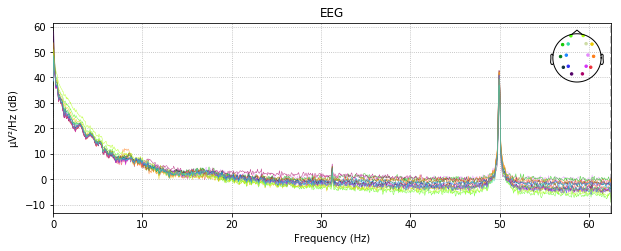

========================= imagery ==========================
Creating RawArray with float64 data, n_channels=17, n_times=152795
    Range : 0 ... 152794 =      0.000 ...  1222.352 secs
Ready.
Effective window size : 16.384 (s)


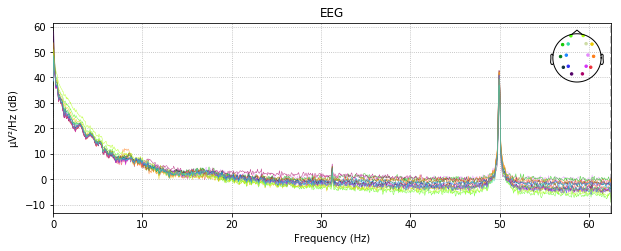

In [5]:
raws = {}
for task_type in task_types:
    print(f"========================= {task_type} ==========================")
    raws[task_type] = df_to_raw(dfs_task_types[task_type])

In [6]:
def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

def get_psd(raw, filter=True): 
    raw_copy = raw.copy()
    if(filter):
        if drift == "drift":
            raw_copy.filter(0.01, 1, method='iir')
        else:
            raw_copy.filter(1, 40, method='iir')
#             raw_copy.plot_psd()     
    psd, freq = mne.time_frequency.psd_welch(raw_copy,n_fft = 96, verbose=False)
    psd =  np.log10(psd)
    mean = psd.mean(0)
    std = psd.std(0)
    return psd, freq, mean, std
#     return raw_copy

def plot_psd(raw):
    psd, freq, mean, std = get_psd(raw)
    fig, ax = plt.subplots(figsize=(10,5))
    for i in range(8):
        ax.plot(freq,psd[i] ,label=raw.info['ch_names'][i], lw=1, alpha=0.6)
    ax.fill_between(250//2, mean - std, mean + std, color='k', alpha=.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitube (dBV)')
    ax.set_title('EEG of ')
    ax.legend()
    plt.show()


In [7]:
event_id = {'0': 1, '1' : 2, '2': 3}
tmin = 0.115 #0
tmax = 0.875
import time
for task_type in task_types:
    X=[]
    picks= mne.pick_types(raws[task_type].info, eeg=True)
    epochs = getEpochs(raws[task_type], event_id, tmin, tmax, picks)
    y = epochs.events[:, -1]
    y = y - 1
    for epoch in epochs.iter_evoked():
        clear_output(wait=True)
#         epoch.plot()
#         time.sleep(2)
        psd,_,_,_ = get_psd(epoch, filter=True)
#         psd = psd.mean(axis=1)
        X.append(psd)
    X = np.array(X)
#     np.save("../data/np/round2/{par}/{drift}/{file}_{task_type}_X".format(par=par, drift = drift, file=file, task_type = task_type), X)
#     np.save("../data/np/round2/{par}/{drift}/{file}_{task_type}_y".format(par=par, drift = drift, file=file, task_type = task_type), y)

Setting up band-pass filter from 0.01 - 1 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 1.00 Hz: -6.02, -6.02 dB



In [8]:
print(X.shape)
print(y.shape)

(150, 16, 49)
(150,)
